# Direct Search

The objective of this notebook is threefold:

1. To determine an appropriate number of scenarios that capture the full range of possible outcomes (repeating simulation)
2. To analyze the nature of uncertainties within the project and how they affect the outcomes (sensitivity analysis)
3. To identify interesting scenarios to use in direct policy search (scenario discovery)

## 0 Setup

In [2]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
import seaborn as sns
from ema_workbench import (Scenario, MultiprocessingEvaluator, ScalarOutcome, ema_logging)
from ema_workbench import  Policy,Scenario,Constraint
from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.em_framework.optimization import (ArchiveLogger,
                                                     EpsilonProgress,
                                                     to_problem, epsilon_nondominated,
                                                     rebuild_platypus_population)
from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from platypus import Hypervolume

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

# parameters for improved visualization
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

## 1 Model Initialization and Optimization

In this process, we integrate targeted scenario-based optimization into the IJssel River flood risk modeling framework. Instead of relying on a generic reference scenario with fixed uncertainty values, we utilize specific "interesting" scenarios—best-case, mediocre-case, and worst-case—previously identified through scenario discovery techniques such as PRIM. These scenarios represent contrasting future conditions relevant for policy evaluation. By extracting the associated uncertainty settings from the selected scenario dataset, we construct a reference Scenario object for each case. This reference scenario is then used to guide the Multi-Objective Evolutionary Algorithm (MOEA) to search for optimal combinations of policy levers that perform well under those specific conditions. This approach enhances the relevance of the optimization process by explicitly tailoring it to scenarios that reflect critical or representative future states, thereby improving the robustness and interpretability of the resulting policy recommendations.

### 1.1 Initialize Model

In [3]:
######## Problem Formulation
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers

'''
# We care about Overijssel, including dike ring 4 and dike ring 5
model.outcomes = [
    ScalarOutcome('A.4_Total Costs', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.4_Expected Annual Damage', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.4_Dike Investment Costs', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.4_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.5_Total Costs', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.5_Expected Annual Damage', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.5_Dike Investment Costs', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('A.5_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome('Expected Evacuation Costs', kind=ScalarOutcome.MINIMIZE)
    
]
'''
outcomes = model.outcomes


In [4]:
# Load the selected cases from CSV
selected_cases = pd.read_csv("selected_cases.csv")

# Extract all uncertainty parameter names from the model
uncertainty_names = [u.name for u in uncertainties]

# Create a dictionary of Scenario instances for each labeled case
scenarios = {}
for case_label in selected_cases["Case"]:
    row = selected_cases[selected_cases["Case"] == case_label].iloc[0]
    filtered_dict = {key: row[key] for key in uncertainty_names if key in row}
    scenarios[case_label] = Scenario(name=case_label, **filtered_dict)

In [5]:
for label, scenario in scenarios.items():
    print(scenario.name)
    print(scenario)

Best
Scenario({'discount rate 0': 3.5, 'discount rate 1': 1.5, 'A.0_ID flood wave shape': 49.0, 'A.1_Bmax': 48.74296694993973, 'A.1_pfail': 0.017929240129888, 'A.1_Brate': 10.0, 'A.2_Bmax': 125.90884536504744, 'A.2_pfail': 0.1029484486207366, 'A.2_Brate': 1.0, 'A.3_Bmax': 126.92545473575592, 'A.3_pfail': 0.5273548662662506, 'A.3_Brate': 1.0, 'A.4_Bmax': 284.70156610012054, 'A.4_pfail': 0.7625849926844239, 'A.4_Brate': 1.0, 'A.5_Bmax': 286.6106006503105, 'A.5_pfail': 0.538627477362752, 'A.5_Brate': 1.5})
Mediocre
Scenario({'discount rate 0': 3.5, 'discount rate 1': 3.5, 'A.0_ID flood wave shape': 105.0, 'A.1_Bmax': 232.43911236524585, 'A.1_pfail': 0.4958078758791089, 'A.1_Brate': 1.0, 'A.2_Bmax': 35.63940763473511, 'A.2_pfail': 0.6704281689599156, 'A.2_Brate': 1.0, 'A.3_Bmax': 169.29511308670044, 'A.3_pfail': 0.5941555732861161, 'A.3_Brate': 1.0, 'A.4_Bmax': 257.1171349287033, 'A.4_pfail': 0.4207521434873342, 'A.4_Brate': 1.0, 'A.5_Bmax': 251.19736909866333, 'A.5_pfail': 0.3167104236781

### 1.2 Search over the decision levers given a set of scenarios

Directed search is most often used to search over the decision levers in order to find good candidate strategies. We utilize this method for all five selected scenarios.


In [6]:
# Function to perform optimization for a given scenario and model
def optimize(scenario, model, nfe, epsilons):
    with MultiprocessingEvaluator(model) as evaluator:
        convergence_metrics = [
            ArchiveLogger(
                "./archives",
                [l.name for l in model.levers],
                [o.name for o in model.outcomes],
                base_filename=f"flood_{scenario.name}_run.tar.gz",
                ),
            EpsilonProgress(),
        ]    

        result, convergence = evaluator.optimize(
            nfe=nfe,
            searchover="levers",
            convergence=convergence_metrics,
            epsilons=epsilons,
            reference=scenario,
        )
    
    return result, convergence

In [7]:
results = []
convergences = []
nfe = 50000  # number of function evaluations

# Iterate over each scenario in the dictionary
for label, scenario in scenarios.items():
    epsilons = [0.1] * len(model.outcomes)
    
    # Run optimization for each scenario object
    result, convergence = optimize(scenario, model, nfe, epsilons)
    results.append(result)
    convergences.append(convergence)




[MainProcess/INFO] pool started with 22 workers
58231it [1:42:42,  9.45it/s]                                                   
[MainProcess/INFO] optimization completed, found 15742 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 22 workers
56207it [1:57:57,  7.94it/s]                                                   
[MainProcess/INFO] optimization completed, found 14328 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████| 50000/50000 [3:06:16<00:00,  4.47it/s]
[MainProcess/INFO] optimization completed, found 16281 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 22 workers
100%|██████████████████████████████████| 50000/50000 [1:32:21<00:00,  9.02it/s]
[MainProcess/INFO] optimization completed, found 11264 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] pool started with 22 workers
100%|███████████████████████████████

In [14]:
results[0]

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.4_Total Costs,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Total Costs,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,1,0,0,0,0,0,1,0,0,0,...,1.610892e+07,1.610892e+07,0.000000e+00,0.000000,1.318329e+08,1.318329e+08,0.000000e+00,0.000000,2.058000e+08,0.000000
1,1,1,1,0,1,0,1,0,1,0,...,2.444716e+07,2.444716e+07,0.000000e+00,0.000000,5.355782e+07,5.355782e+07,0.000000e+00,0.000000,7.950000e+08,260.683752
2,1,1,1,0,0,1,1,0,0,0,...,3.476877e+07,3.476877e+07,0.000000e+00,0.000000,7.944417e+07,7.944417e+07,0.000000e+00,0.000000,5.389000e+08,260.756127
3,0,1,1,0,1,0,0,1,0,0,...,1.390342e+07,1.390342e+07,0.000000e+00,0.000000,2.757823e+07,2.757823e+07,0.000000e+00,0.000000,4.543000e+08,3379.789117
4,1,1,1,1,0,0,1,1,1,0,...,3.518215e+07,3.518215e+07,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.103300e+09,883.789367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15737,1,0,0,1,0,0,0,0,0,0,...,1.426165e+07,1.426165e+07,0.000000e+00,0.000000,2.757823e+07,2.757823e+07,0.000000e+00,0.000000,3.024000e+08,19178.404947
15738,0,0,0,0,0,0,0,0,0,0,...,3.073543e+06,0.000000e+00,3.073543e+06,0.000154,3.825225e+07,2.757823e+07,1.067402e+07,0.001646,0.000000e+00,6639.316172
15739,0,1,1,1,0,1,0,0,0,0,...,2.600839e+07,2.600839e+07,0.000000e+00,0.000000,1.922134e+07,0.000000e+00,1.922134e+07,0.001266,5.509000e+08,7153.977817
15740,1,0,1,0,0,0,0,0,0,0,...,8.453408e+06,8.453408e+06,0.000000e+00,0.000000,8.514240e+07,8.514240e+07,0.000000e+00,0.000000,3.024000e+08,15531.853455


### 1.3 Tracking convergence

An important part of using many-objective evolutionary algorithms is to carefully monitor whether they have converged to the best possible solutions. Various different metrics can be used for this. Here, we use ε-progress. 


In [33]:
def plot_epsilon_progress(convergences, labels):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set_style("white")
    plt.figure(figsize=(6, 4))

    colors = sns.color_palette("colorblind", len(labels))

    for i, (convergence, label) in enumerate(zip(convergences, labels)):
        color = colors[i]
        plt.plot(convergence.nfe, convergence.epsilon_progress, label=label, color=color)

    plt.ylabel(r'$\epsilon$ progress')
    plt.xlabel("Function Evaluations (NFE)")
    plt.legend(title="Scenario")
    sns.despine()
    plt.tight_layout()
    plt.show()


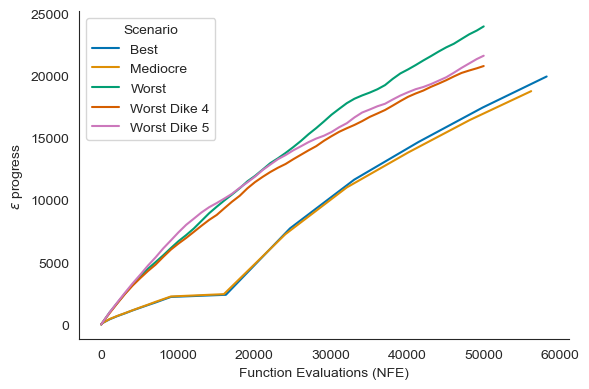

In [34]:
plot_epsilon_progress(convergences, list(scenarios.keys()))

### 1.4 Parallel coordinate plots

We make parallel axis plots through the parcoords module. This module offers a parallel axes object on which we can plot data. The typical workflow is to first instantiate this parallel axes object given a pandas dataframe with the upper and lower limits for each axes. Next, one or more datasets can be plotted on this axes. Any dataframe passed to the plot method will be normalized using the limits passed first. We can also invert any of the axes to ensure that the desirable direction is the same for all axes.


In [58]:
type(results)

list

In [59]:
# define scenario labels in correct order
# replace the ' ' with '_' in scenario labels
scenario_labels = [label.replace(' ', '_') for label in list(scenarios.keys())]

scenario_labels


['Best', 'Mediocre', 'Worst', 'Worst_Dike_4', 'Worst_Dike_5']

Modify later based on results

In [60]:
# Process each result DataFrame with its scenario name
processed_results = []
for df, label in zip(results, scenario_labels):
    df = df.copy()
    df["scenario"] = label

    # Create aggregate columns
    df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
    df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
    df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
    df["Overijssel_RfR_num"] = df[[f"{i}_RfR 0" for i in [3, 4]]].sum(axis=1)

    processed_results.append(df)

    # Save to CSV immediately
    df.to_csv(f"optimization_results_{label}.csv", index=False)

In [61]:
# define outcomes to plot
outcomes_of_interest = [
    "Overijssel_Deaths",
    "Overijssel_Damages",
    "Overijssel_Investment",
    "Overijssel_RfR_num"
]

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


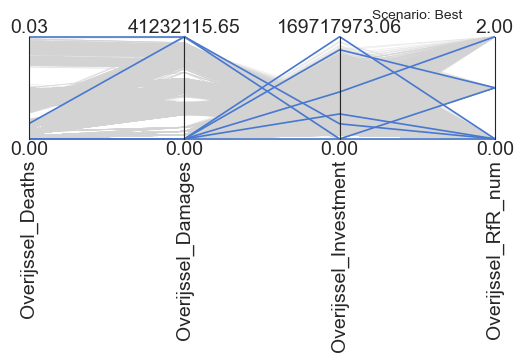

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


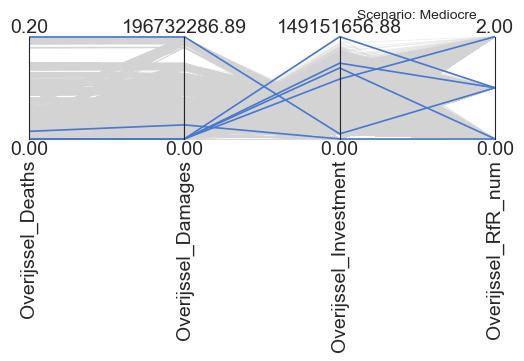

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


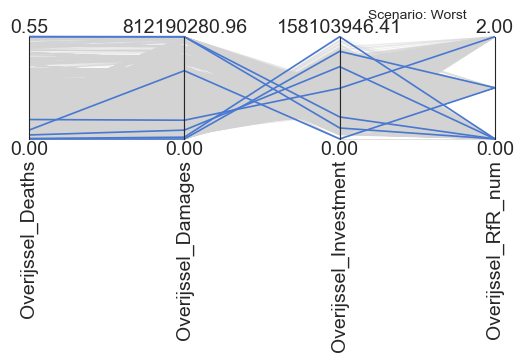

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


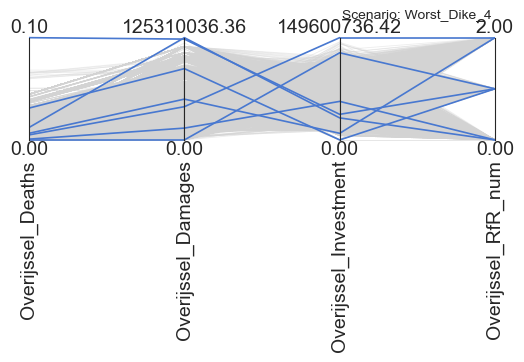

C:\Users\yaowa\AppData\Local\Temp\ipykernel_23240\484808034.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


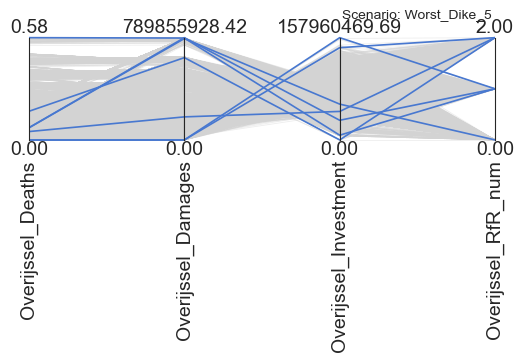

In [62]:
# Loop over each scenario result
for df, label in zip(processed_results, scenario_labels):
    subset = df[outcomes_of_interest]
    
    # Get the indices of min and max values
    indices = pd.concat([subset.idxmax(), subset.idxmin()]).unique()

    # Define limits for the axes
    limits = parcoords.get_limits(subset)
    axes = parcoords.ParallelAxes(limits)
    
    # Grey for background
    axes.plot(subset, color='lightgrey', alpha=0.4, lw=0.6)

    # Highlight min/max in color
    axes.plot(subset.loc[indices], color=sns.color_palette("muted")[0], lw=1.2)

    # Title and layout
    plt.title(f"Scenario: {label}", fontsize=10)
    plt.gcf().set_size_inches((5, 2))  # Control figure size tightly
    plt.tight_layout()
    plt.show()
 

## 2 Robust Evaluation

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertain factors to assess their robustness against uncertainties. For this robustness evaluation, we need to explore the scenarios for each solution. 

### 2.1 Signal-to-noise ratio

First, we use *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation is different.


Copy from assignment 9, modify later

In [ ]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in lake_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')
plt.show()

### 2.2 Maximum Regret

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the berformance of a no-regret (i.e. best possible result in that scenario) policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. 


Copy from assignment 9, modify later

In [ ]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
overall_regret = {}
max_regret = {}
for outcome in lake_model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

**Discussion**

